In [296]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.backend import clear_session
import gc
#from eli5.sklearn import PermutationImportance

In [297]:
data = pd.read_csv('all_data_results_cleaned.csv')

In [298]:
"""mask = data["support"] == "Fixed_Free"
data = data.drop(data[~mask].index)"""

'mask = data["support"] == "Fixed_Free"\ndata = data.drop(data[~mask].index)'

In [299]:
data["total_length"] = data["length1"] + data["length2"]
data["x_length"] = data["length2"] + data["x_deformation_position"]
data["x_ratio"] = data["x_length"]/data["total_length"]
data["flange_postion_ratio"] = data["length2"]/data["total_length"]

In [300]:
to_drop=["pipe_dn","pipe_schedule","flange_class",
        "hot_spot_stress", "max_deformation", "support_right", "support_left", "ratio",
        "y_deformation_position", "z_deformation_position", "x_deformation_position",
        "length1", "length2", "x_length"
        ]
to_keep=["outside_diameter", "wall_thickness", "raised_face_depth",
        "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius",
        "total_length", "x_ratio","flange_postion_ratio"
        "lumped_mass", "frequency",
        "support", "allowable_deformation"]

data.drop(columns=to_drop,inplace=True)

In [301]:
numeric_features = ["outside_diameter", "wall_thickness", "raised_face_depth" ,'total_length', 'lumped_mass',
                    "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius","flange_postion_ratio"]
categorical_features = ['support']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [302]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [303]:
output_columns = ['allowable_deformation', 'frequency', 'x_ratio']
x = data.drop(output_columns, axis=1)
y = pd.DataFrame(data[output_columns])

In [304]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [305]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [306]:
scaler_y_frequency = StandardScaler()
scaler_y_allowable_deformation = StandardScaler()
scaler_y_x_ratio = StandardScaler()


#y_train_transformed_frequency = scaler_y_frequency.fit_transform(pd.DataFrame(y_train["frequency"]))
#y_test_transformed_frequency = scaler_y_frequency.transform(pd.DataFrame(y_test["frequency"]))

#y_train_transformed_allowable_deformation = scaler_y_allowable_deformation.fit_transform(pd.DataFrame(y_train["allowable_deformation"]))
#y_test_transformed_allowable_deformation = scaler_y_allowable_deformation.transform(pd.DataFrame(y_test["allowable_deformation"]))

y_train_transformed_x_ratio = scaler_y_x_ratio.fit_transform(pd.DataFrame(y_train["x_ratio"]))
y_test_transformed_x_ratio = scaler_y_x_ratio.transform(pd.DataFrame(y_test["x_ratio"]))

#y_train_transformed_x_ratio = np.array(y_train["x_ratio"])
#y_test_transformed_x_ratio = np.array(y_test["x_ratio"])

In [307]:
logdir = "logs/x_ratio_measurements/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [308]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(128, activation='relu')(input_layer)



# Separate output for each target variable
output_layer = Dense(1)(hidden1)
#, name='allowable_deformation'


In [309]:
model = Model(inputs=input_layer, outputs=output_layer)

In [310]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,049 (8.00 KB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

In [311]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mse',
              metrics=["R2Score"])

In [312]:
history = model.fit(
    x_train_transformed, 
    y_train_transformed_x_ratio,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - R2Score: 0.4828 - loss: 0.5219 - val_R2Score: 0.9272 - val_loss: 0.0699
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - R2Score: 0.9365 - loss: 0.0638 - val_R2Score: 0.9368 - val_loss: 0.0607
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - R2Score: 0.9414 - loss: 0.0590 - val_R2Score: 0.9404 - val_loss: 0.0572
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - R2Score: 0.9429 - loss: 0.0572 - val_R2Score: 0.9442 - val_loss: 0.0536
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - R2Score: 0.9472 - loss: 0.0535 - val_R2Score: 0.9437 - val_loss: 0.0541
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9538 - loss: 0.0463 - val_R2Score: 0.9457 - val_loss: 0.0521
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - R2Score: 0.9543 - loss: 0.0458 - val_R2Score: 0.9419 - val_loss: 0.0558
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - R2Score: 0.9501 - loss: 0.0517 - val_R2Score: 0.9471 

In [313]:
test_loss, test_mse = model.evaluate(x_test_transformed, y_test_transformed_x_ratio)
print('Test accuracy:', test_mse)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - R2Score: 0.9733 - loss: 0.0268
Test accuracy: 0.9751332402229309


In [314]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,149 (24.02 KB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,100 (16.02 KB)

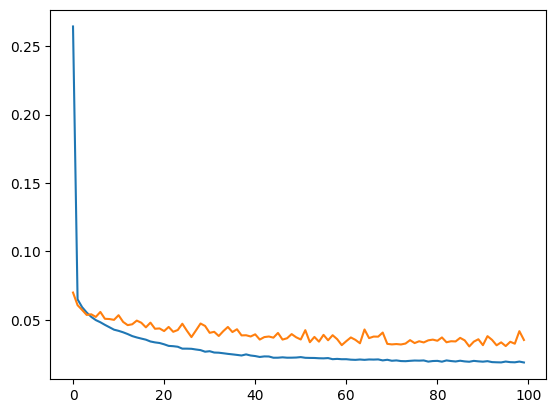

In [315]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")

In [316]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y_x_ratio.inverse_transform((predictions_scaled))
#predictions = predictions_scaled

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [317]:
predictions_df = pd.DataFrame(predictions)
print("\nSample Predictions:")
print(predictions_df)


Sample Predictions:
             0
0     0.486759
1     0.425703
2     0.390298
3     0.569168
4     0.583207
...        ...
2452  0.325049
2453  0.493657
2454  0.422951
2455  0.465139
2456  0.209003

[2457 rows x 1 columns]


In [318]:
y_test["x_ratio"]

524      0.510389
10325    0.453171
11646    0.390113
10238    0.607627
10214    0.601682
           ...   
11507    0.330878
2709     0.506525
12218    0.387399
2858     0.465529
9935     0.205541
Name: x_ratio, Length: 2457, dtype: float64

In [319]:
true= y_test["x_ratio"].tolist()
pred= predictions_df[0].tolist()
mean_squared_error(true,pred)

0.0017019263140745336

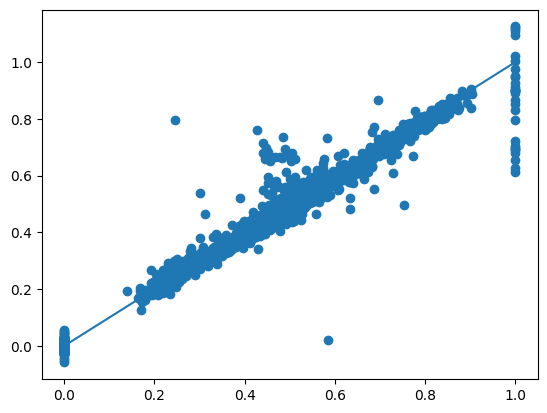

In [320]:
pred=predictions_df
ansys=y_test["x_ratio"]
plt.scatter(ansys,pred)
#plt.loglog()
plt.plot([0, 1],[0, 1])
plt.show()

In [321]:
#clear_session()
#del model
gc.collect()

9257

In [322]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          data:  1.9 MiB
                          _172:  1.8 MiB
                             x:  1.6 MiB
                       x_train:  1.4 MiB
           x_train_transformed:  1.0 MiB
                           _54: 998.2 KiB
                          _173: 459.6 KiB
                        x_test: 356.4 KiB
                       y_train: 307.1 KiB
                          _114: 307.1 KiB


In [324]:
model.layers[1].get_weights()[0]

array([[-0.09373803,  0.03846753, -0.02358959, ..., -0.12983751,
        -0.04012703,  0.06368446],
       [ 0.16355173,  0.02279248,  0.03763612, ...,  0.2931354 ,
        -0.00792975, -0.25357032],
       [ 0.2268051 , -0.01314423,  0.2448857 , ..., -0.19109231,
        -0.06653697,  0.0366512 ],
       ...,
       [-0.16213645, -0.8142065 ,  0.05380281, ...,  0.31030127,
        -0.23131639,  0.00142383],
       [-0.02295437,  0.15810794, -0.21950945, ...,  0.08019531,
        -0.14220789,  0.0740904 ],
       [ 0.0075564 ,  0.3914774 , -0.70673615, ...,  0.1250143 ,
        -0.1402858 , -0.03171911]], dtype=float32)